### Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts

KeyError: 0

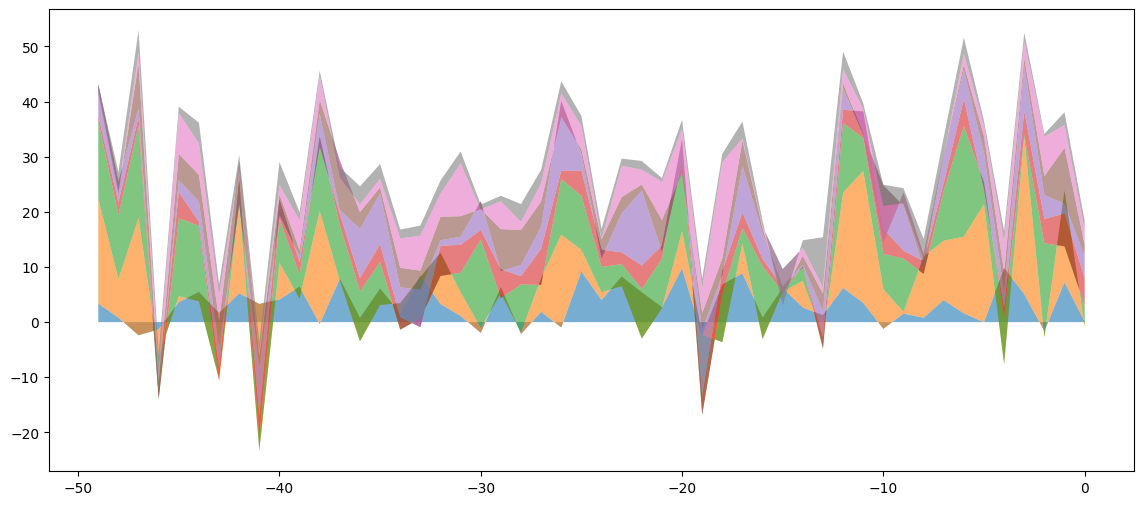

In [2]:
import pandas as pd
from scripts.db_loader import load_csv_to_db, connect_to_db
from scripts.synthetic_generator import generate_synthetic_data
from scripts.model_utils import train_regression_models, analyze_residuals, detect_anomalies
from scripts.plot_utils import plot_stream_combined_with_summary, plot_stream_with_regression
from scripts.log_utils import log_to_csv, display_summary_stats
from sqlalchemy import text
import time

# Step 0: Connect to Neon DB
print("🔌 Connecting to Neon DB...")
engine = connect_to_db()
if engine is None:
    print("❌ Failed to connect to the database. Exiting.")
    exit(1)
print("✅ Connected to the database.")

# Step 1: Load and train on original data
print("📥 Loading training data...")
df_train = pd.read_csv("data/RMBR4-2_export_test.csv")

# Clean and prepare
axis_cols = [col for col in df_train.columns if "Axis" in col]
df_train[axis_cols] = df_train[axis_cols].fillna(0.0)
df_train["Time"] = pd.to_datetime(df_train["Time"], errors='coerce')

# Save original data to DB
print("💾 Saving training data to Neon DB...")
load_csv_to_db("data/RMBR4-2_export_test.csv", engine, table_name="cat_dataset")

# Display stats
display_summary_stats(df_train, "Original Data")
print(df_train.head())

# Train models
print("\n📈 Training regression models...")
models = train_regression_models(df_train)

# Discover thresholds
print("\n🔍 Discovering thresholds from residuals...")
thresholds = analyze_residuals(df_train, models)

# Step 2: Generate synthetic test data
print("\n🧪 Generating synthetic test data with anomalies...")
df_test = generate_synthetic_data("data/RMBR4-2_export_test.csv", output_csv=None)

# Convert Time column to datetime
df_test["Time"] = pd.to_datetime(df_test["Time"], errors='coerce')

# Save synthetic data to Neon DB
df_test.to_sql("synthetic_stream", engine, if_exists="replace", index=False)

# Display stats
display_summary_stats(df_test, "Synthetic Data")
print(df_test.head())

# Step 3: Simulate streaming
print("\n📡 Starting live streaming simulation from Neon DB...")

# Initialize history with correct schema
df_schema = pd.read_sql("SELECT * FROM synthetic_stream LIMIT 1", engine)
history_df = pd.DataFrame(columns=df_schema.columns).astype(df_schema.dtypes.to_dict())

# Get total number of rows
row_count = pd.read_sql("SELECT COUNT(*) FROM synthetic_stream", engine).iloc[0, 0]

for i in range(row_count):
    # Read next row from DB
    query = text(f"SELECT * FROM synthetic_stream ORDER BY \"Time\" ASC LIMIT 1 OFFSET {i}")
    new_row = pd.read_sql(query, engine)

    # Append to history
    history_df = pd.concat([history_df, new_row], ignore_index=True)

    # Detect anomalies in the new row
    alerts, errors = detect_anomalies(new_row, models, thresholds)

    # Print anomalies
    if alerts or errors:
        print(f"\n⏱️ Time index {i}: {len(alerts)} alerts, {len(errors)} errors")
        for a in alerts:
            print(f"⚠️ Alert on {a['axis']} at index {a['index']}: {a['value']:.2f}")
        for e in errors:
            print(f"❌ Error on {e['axis']} at index {e['index']}: {e['value']:.2f}")

    # Plot last 50 rows with current alerts/errors only
    plot_df = history_df.tail(50).copy()
    plot_stream_combined_with_summary(plot_df, alerts, errors)

    # Wait 2 seconds before next row
    time.sleep(2)

# Step 4: Save alerts and errors to CSV
log_to_csv(alerts, "logs/alerts.csv")
log_to_csv(errors, "logs/errors.csv")